In [150]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from interpret import show
from interpret.glassbox import (
    ExplainableBoostingRegressor,
    ExplainableBoostingClassifier,
)
from sklearn.metrics import auc, mean_tweedie_deviance
from sklearn.model_selection import cross_val_score, KFold

In [31]:
freq_data = pl.read_csv(
    "./data/insurance/freMTPL2freq.csv", schema_overrides={"IDpol": pl.Float64}
)
sev_data = (
    pl.read_csv(
        "./data/insurance/freMTPL2sev.csv", schema_overrides={"IDpol": pl.Float64}
    )
    .group_by("IDpol")
    .agg(pl.col("ClaimAmount").clip(upper_bound=250000).sum())
)

data = (
    freq_data.join(sev_data, on="IDpol", how="left", coalesce=True)
    .with_columns(pl.col("ClaimAmount").fill_null(0))
    .with_columns(PurePremium=pl.col("ClaimAmount") / pl.col("Exposure"))
)

data = data.sample(50000, seed=5)

# Pure Premium Model

In [32]:
X = data.select(
    pl.col(
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    )
)
y = data["PurePremium"]

In [144]:
model = ExplainableBoostingRegressor(
    feature_names=X.columns,
    feature_types=[
        "nominal",
        "continuous",
        "continuous",
        "continuous",
        "continuous",
        "nominal",
        "nominal",
        "continuous",
        "nominal",
    ],
    objective="tweedie_deviance:variance_power=1.7",
    interactions=0,
    # outer_bags=28
    # validation_size=0.50,
    # smoothing_rounds=2000,
)
model.fit(X, y)

ExplainableBoostingRegressor(feature_names=['Area', 'VehPower', 'VehAge',
                                            'DrivAge', 'BonusMalus', 'VehBrand',
                                            'VehGas', 'Density', 'Region'],
                             feature_types=['nominal', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'nominal', 'nominal',
                                            'continuous', 'nominal'],
                             interactions=0,
                             objective='tweedie_deviance:variance_power=1.7',
                             outer_bags=56, smoothing_rounds=800)

In [145]:
for idx, term in enumerate(model.bagged_scores_):
    median = np.median(term, axis=0)
    mad = np.median(np.abs(term - median), axis=0)
    model.term_scores_[idx] = median
    model.standard_deviations_[idx] = mad

model.intercept_ = np.median(model.bagged_intercept_)

In [146]:
show(model.explain_global())

<!-- http://127.0.0.1:7001/11483536080/ -->

In [148]:
def lorenz_curve(pp_true, pp_pred, exposure):
    pp_true, pp_pred, exposure = (
        np.asarray(pp_true),
        np.asarray(pp_pred),
        np.asarray(exposure),
    )

    # order actual pure premium and exposure
    # by increasing predicted pure premium:
    order = np.argsort(pp_pred)
    ordered_pp = pp_true[order]
    ordered_exposure = exposure[order]

    cumulative_loss = np.cumsum(ordered_pp * ordered_exposure)
    cumulative_loss /= cumulative_loss[-1]
    exposure_percent = np.linspace(0, 1, len(exposure))
    return exposure_percent, cumulative_loss


def plot_lorenz_curve(pp_true, pp_pred, exposure):
    exp_percent, cum_loss = lorenz_curve(pp_true, pp_pred, exposure)
    # See https://en.wikipedia.org/wiki/Gini_coefficient#Definition
    model_gini = round(1 - 2 * auc(exp_percent, cum_loss), 2)
    _, cum_loss_oracle = lorenz_curve(pp_true, pp_true, exposure)
    oracle_gini = round(1 - 2 * auc(exp_percent, cum_loss_oracle), 2)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(
        exp_percent, cum_loss, color="tab:blue", label=f"Model (Gini: {model_gini})"
    )
    ax.plot(
        exp_percent,
        cum_loss_oracle,
        color="tab:orange",
        alpha=0.5,
        label=f"Oracle (Gini: {oracle_gini})",
    )
    ax.plot(
        [0, 1],
        [0, 1],
        linestyle="dashed",
        color="tab:gray",
        alpha=0.5,
        label="Random (Gini: 0)",
    )
    ax.legend()
    ax.set_xlabel("Percent of Exposure")
    ax.set_ylabel("Percent of Losses")


def compute_gini(pp_true, pp_pred, exposure):
    exp_percent, cum_loss = lorenz_curve(pp_true, pp_pred, exposure)
    return 1 - 2 * auc(exp_percent, cum_loss)


def gini_scorer(estimator, X, y, exposure):
    pred = estimator.predict(X)
    exp_percent, cum_loss = lorenz_curve(y, pred, exposure)
    return 1 - 2 * auc(exp_percent, cum_loss)

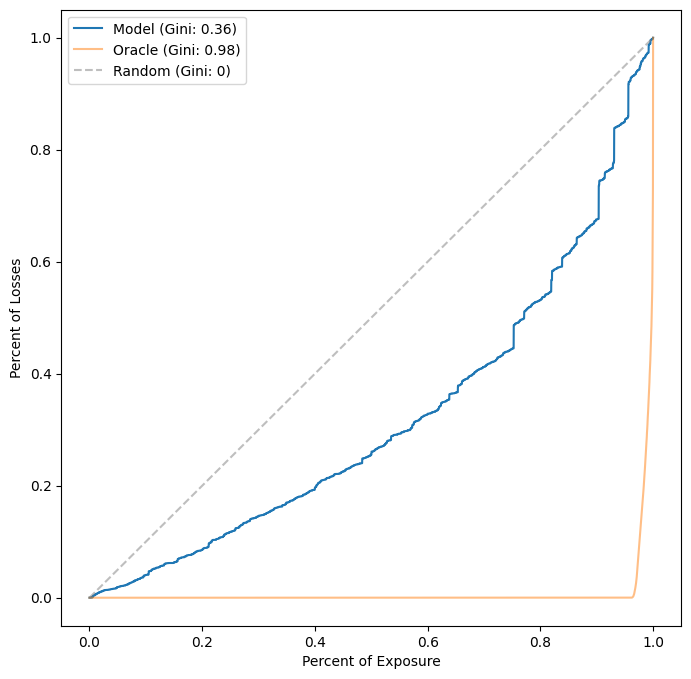

In [149]:
plot_lorenz_curve(y, model.predict(X), data["Exposure"])

### Cross-Validation

In [181]:
splitter = KFold(n_splits=10)

model = ExplainableBoostingRegressor(
    feature_names=X.columns,
    feature_types=[
        "nominal",
        "continuous",
        "continuous",
        "continuous",
        "continuous",
        "nominal",
        "nominal",
        "continuous",
        "nominal",
    ],
    objective="tweedie_deviance:variance_power=1.7",
    interactions=0,
)

losses = []
for train_idx, test_idx in splitter.split(X, y):
    model.fit(X[train_idx], y[train_idx])

    # ----- Median Adjustment -----
    for idx, term in enumerate(model.bagged_scores_):
        median = np.median(term, axis=0)
        mad = np.median(np.abs(term - median), axis=0)
        model.term_scores_[idx] = median
        model.standard_deviations_[idx] = mad

    model.intercept_ = np.median(model.bagged_intercept_)
    # -----------------------------

    model_out = model.predict(X[test_idx])
    loss = mean_tweedie_deviance(y[test_idx], model_out, power=1.7)
    losses.append(loss)

    print("iteration complete")

iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete


In [182]:
np.mean(losses)

49.87414185077655

In [163]:
splitter = KFold(n_splits=10)

model = ExplainableBoostingRegressor(
    feature_names=X.columns,
    feature_types=[
        "nominal",
        "continuous",
        "continuous",
        "continuous",
        "continuous",
        "nominal",
        "nominal",
        "continuous",
        "nominal",
    ],
    objective="tweedie_deviance:variance_power=1.7",
    interactions=0,
)

mean_losses = []
for train_idx, test_idx in splitter.split(X, y):
    model.fit(X[train_idx], y[train_idx])

    model_out = model.predict(X[test_idx])
    loss = mean_tweedie_deviance(y[test_idx], model_out, power=1.7)
    mean_losses.append(loss)

    print("iteration complete")

iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete
iteration complete


In [180]:
np.mean(mean_losses)

49.924058183738566

# Hurdle Model

In [47]:
freq_X = data.select(
    pl.col(
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    )
)
freq_y = data.select((pl.col("PurePremium") > 0).cast(pl.Int64))

freq_model = ExplainableBoostingClassifier(
    feature_names=X.columns,
    feature_types=[
        "nominal",
        "continuous",
        "continuous",
        "continuous",
        "continuous",
        "nominal",
        "nominal",
        "continuous",
        "nominal",
    ],
    # interactions=0,
    validation_size=0.50,
    outer_bags=50,
)
freq_model.fit(freq_X, freq_y)

ExplainableBoostingClassifier(feature_names=['Area', 'VehPower', 'VehAge',
                                             'DrivAge', 'BonusMalus',
                                             'VehBrand', 'VehGas', 'Density',
                                             'Region'],
                              feature_types=['nominal', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'nominal', 'nominal',
                                             'continuous', 'nominal'],
                              outer_bags=50, validation_size=0.5)

In [50]:
show(freq_model.explain_global())

In [137]:
freq_cv_scores = cross_val_score(
    freq_model, freq_X.to_pandas(), freq_y.to_pandas(), scoring="roc_auc", cv=10
)

In [138]:
np.mean(freq_cv_scores)

0.6356914802462518

In [33]:
sev_data = data.filter(pl.col("PurePremium") > 0)
sev_X = sev_data.select(
    pl.col(
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    )
)
sev_y = sev_data["PurePremium"]

sev_model = ExplainableBoostingRegressor(
    feature_names=X.columns,
    feature_types=[
        "nominal",
        "continuous",
        "continuous",
        "continuous",
        "continuous",
        "nominal",
        "nominal",
        "continuous",
        "nominal",
    ],
    # interactions=0,
    objective="gamma_deviance",
    validation_size=0.50,
    outer_bags=50,
)
sev_model.fit(sev_X, sev_y)

ExplainableBoostingRegressor(feature_names=['Area', 'VehPower', 'VehAge',
                                            'DrivAge', 'BonusMalus', 'VehBrand',
                                            'VehGas', 'Density', 'Region'],
                             feature_types=['nominal', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'nominal', 'nominal',
                                            'continuous', 'nominal'],
                             objective='gamma_deviance', outer_bags=50,
                             validation_size=0.5)

In [34]:
show(sev_model.explain_global())

In [36]:
sev_cv_scores = cross_val_score(
    sev_model, sev_X.to_pandas(), sev_y.to_pandas(), scoring="r2", cv=10
)

In [37]:
np.mean(sev_cv_scores)

-0.01037947527169224

In [38]:
full_X = data.select(
    pl.col(
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    )
)
full_y = data["PurePremium"]

(array([8.400e+01, 1.380e+02, 4.600e+02, 1.194e+03, 2.404e+03, 3.745e+03,
        4.630e+03, 4.828e+03, 4.759e+03, 4.236e+03, 3.688e+03, 3.346e+03,
        2.725e+03, 2.160e+03, 1.884e+03, 1.523e+03, 1.195e+03, 1.046e+03,
        9.200e+02, 7.320e+02, 6.740e+02, 4.820e+02, 4.290e+02, 3.420e+02,
        3.100e+02, 2.540e+02, 1.860e+02, 1.960e+02, 1.710e+02, 1.310e+02,
        9.600e+01, 9.300e+01, 7.400e+01, 6.800e+01, 5.400e+01, 5.000e+01,
        4.400e+01, 5.100e+01, 3.700e+01, 3.200e+01, 3.600e+01, 2.300e+01,
        3.200e+01, 3.500e+01, 2.500e+01, 2.900e+01, 2.900e+01, 2.700e+01,
        1.700e+01, 1.900e+01, 2.000e+01, 1.700e+01, 1.500e+01, 1.100e+01,
        1.700e+01, 1.200e+01, 9.000e+00, 1.300e+01, 1.300e+01, 1.700e+01,
        1.000e+01, 8.000e+00, 1.000e+01, 7.000e+00, 9.000e+00, 6.000e+00,
        4.000e+00, 8.000e+00, 7.000e+00, 5.000e+00, 6.000e+00, 4.000e+00,
        2.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+0

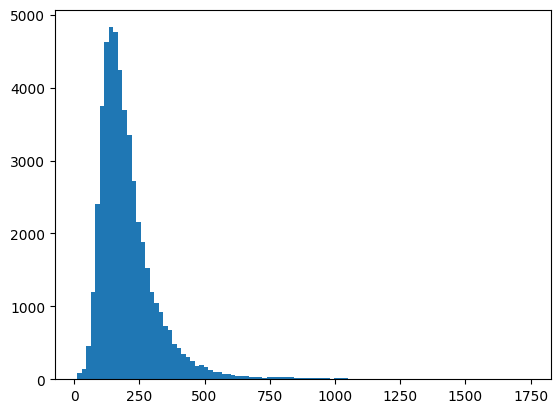

In [44]:
plt.hist(sev_model.predict(full_X) * freq_model.predict_proba(full_X)[:, 1], bins=100)

# Weighted Quantile Bins

In [89]:
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix]  # sort data
    weights = weights[ix]  # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(
        weights
    )  # 'like' a CDF function
    return np.interp(perc, cdf, data)


def make_q_cuts(values, weights, n_cuts):
    quantiles = [(i + 1) / n_cuts for i in range(n_cuts - 1)]
    weighted_cuts = [
        weighted_percentile(values.to_numpy(), weights.to_numpy(), q) for q in quantiles
    ]
    return list(np.unique(weighted_cuts))

In [90]:
max_cuts = 1024
X = data.select(
    pl.col(
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    )
)
y = data["PurePremium"]

model = ExplainableBoostingRegressor(
    feature_names=X.columns,
    feature_types=[
        "nominal",
        make_q_cuts(data["VehPower"], data["Exposure"], 1024),
        make_q_cuts(data["VehAge"], data["Exposure"], 1024),
        make_q_cuts(data["DrivAge"], data["Exposure"], 1024),
        make_q_cuts(data["BonusMalus"], data["Exposure"], 1024),
        "nominal",
        "nominal",
        make_q_cuts(data["Density"], data["Exposure"], 1024),
        "nominal",
    ],
    interactions=0,
    objective="tweedie_deviance:variance_power=1.7",
    # outer_bags=50,
)
model.fit(X, y)

ExplainableBoostingRegressor(feature_names=['Area', 'VehPower', 'VehAge',
                                            'DrivAge', 'BonusMalus', 'VehBrand',
                                            'VehGas', 'Density', 'Region'],
                             feature_types=['nominal',
                                            [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                             11.0, 12.0, 13.0, 14.0, 15.0],
                                            [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0,
                                             7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
                                             13.0, 14.0, 15.0, 16.0, 17.0, 18.0,
                                             19.0, 20.0, 21.0, 22.0, 23.0, 24.0,
                                             25.0, 27.0, 29.0, 31.0...
                                             56.0, 57.0, 58.0, 59.0, 60.0, 61.0,
                                             62.0, 63.0, 64.0, 65.0, 66.0, 67.0,
                                             68.0, 69.0, 70.0, 71.0, 72.0, 73.0,
                                             74.0, 75.0, 76.0, 77.0, 78.0, 80.0, ...],
                                            'nominal', 'nominal',
                                            [4.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                             11.0, 12.0, 13.0, 14.0, 15.0, 16.0,
                                             17.0, 18.0, 19.0, 20.0, 21.0, 22.0,
                                             23.0, 24.0, 25.0, 26.0, 27.0, 28.0,
                                             29.0, 30.0, 31.0, 32.0, 33.0, 34.0, ...],
                                            'nominal'],
                             interactions=0,
                             objective='tweedie_deviance:variance_power=1.7')

In [91]:
show(model.explain_global())